Python version used: **3.9.13**

Imports:

In [237]:
# torch imports
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader

# sklearn imports
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.preprocessing import PolynomialFeatures,StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# gensim imports
from gensim.models import Word2Vec
from gensim import utils

# other imports
import csv
import PIL
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Check that CUDA is available (when using my own system):

In [238]:
torch.cuda.is_available()

True

# Q1:

(a)

Open and read dataset:

In [239]:
with open("PADL-Q1.csv") as q1_file:
  q1_data = []
  q1_dataset = csv.reader(q1_file, delimiter=',')
  for row in q1_dataset:
    if row[0] != 'x1':
      q1_data.append(row)

Apply PCA using 5 components, equal to number of variables in dataset. The displayed result is the percentage of variance each variable accounts for:

In [240]:
pca = PCA(n_components=5)
pca.fit(q1_data)
newData = pca.fit_transform(q1_data)
pca_var_percentage = pca.explained_variance_ratio_
for i in range(len(pca_var_percentage)):
  print(f'x{i} accounts for {(pca_var_percentage[i]*100):f}% of the variance')

x0 accounts for 53.846279% of the variance
x1 accounts for 30.067823% of the variance
x2 accounts for 10.263250% of the variance
x3 accounts for 4.605826% of the variance
x4 accounts for 1.216823% of the variance


Calculate how much information is lost when reducing dimensions of data:

In [241]:
three_dims = pca_var_percentage[0]+pca_var_percentage[1]+pca_var_percentage[2]
print("Information retained with 3 variables = %f%%\n"%(three_dims*100.0))
print("Information retained with 4 variables = %f%%"%((three_dims + pca_var_percentage[3])*100.0))

Information retained with 3 variables = 94.177351%

Information retained with 4 variables = 98.783177%


Reducing the dimensionality of the dataset by 1 dimension causes information loss of 1.22%. Reducing it by 2 dimensions (down to 3) causes information loss of 5.82% however it is now possible to plot the dataset on a 3D axis, whereas this is not possible with 4 dimensions. Therefore, D_min = 3.





(b)

Repeat PCA with new D_min=3:

In [242]:
pca2 = PCA(n_components=3)
pca2.fit(q1_data)
newData2 = pca2.fit_transform(q1_data)
pca2_components = pca2.components_

Print equations for each of the three principal components as a function of the original 5 variables:

In [243]:
i = 1
for line in pca2_components:
    print("PC%i: %f*x1 + %f*x2 + %f*x3 + %f*x4 + %f*x5\n"%(i,line[0],line[1],line[2],line[3],line[4]))
    i+=1

PC1: -0.092819*x1 + 0.025272*x2 + -0.348770*x3 + 0.145083*x4 + -0.920900*x5

PC2: 0.005624*x1 + -0.298705*x2 + -0.114221*x3 + -0.940623*x4 + -0.113695*x5

PC3: 0.112668*x1 + -0.133156*x2 + 0.914203*x3 + -0.023934*x4 + -0.365014*x5



# Q2:

Read and split dataset into _data_ and _targets_ Pandas dataframes:

In [244]:
q2_data = pd.read_csv("PADL-Q2-train.csv")
q2_target = q2_data['out']
q2_data = q2_data.drop('out',axis=1)
X,y = q2_data[['x','y','z','w']],q2_target

In [245]:
print(X.shape)
print(y.shape)

(80, 4)
(80,)


Plot each variable against the output:

Text(0.5, 1.0, 'w')

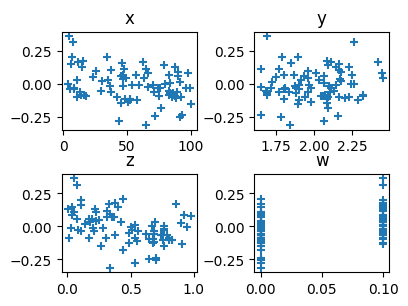

In [246]:
fig,ax = plt.subplots(nrows=2,ncols=2,figsize=(4,3))
fig.tight_layout()
ax[0][0].scatter(q2_data['x'],q2_target,marker='+')
ax[0][0].set_title("x")
ax[0][1].scatter(q2_data['y'],q2_target,marker='+')
ax[0][1].set_title("y")
ax[1][0].scatter(q2_data['z'],q2_target,marker='+')
ax[1][0].set_title("z")
ax[1][1].scatter(q2_data['w'],q2_target,marker='+')
ax[1][1].set_title("w")

(a)

The function _polynomial_basis_ returns the basis functions for a fit of the data to an n degree polynomial, along with fitting and transforming them to the data

In [247]:
def polynomial_basis(X,degree):
    poly = PolynomialFeatures(degree,include_bias=False)
    functions = poly.fit(X).get_feature_names_out()
    return functions,poly.fit_transform(X)

The function _scale_data_ scales the data using a scaler provided in sklearn

In [248]:
def scale_data(X_train,X_test,scaler):
    scaler = scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled

The function _evaluate_basis_ takes the train and test data and applies the _polynomial_basis_ function to it, along with scaling if necessary, and outputs the R^2 score as well as the basis functions for a given degree polynomial fit to a LinearRegression model

In [249]:
def evaluate_basis(X_train, X_test, y_train, y_test, transform_func, scaler=None, **transform_params):
    # Data scaling
    if scaler:
        X_train, X_test = scale_data(X_train, X_test, scaler)

    # Get poly basis functions
    X_train_basis_functions,X_train_transformed = transform_func(X_train, **transform_params)
    X_test_basis_functions,X_test_transformed = transform_func(X_test, **transform_params)

    model = LinearRegression()
    model.fit(X_train_transformed, y_train)

    y_train_pred = model.predict(X_train_transformed)
    y_test_pred = model.predict(X_test_transformed)

    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    return train_r2, test_r2, X_train_basis_functions

Print out result of running the above function for various degree polynomials:

In [250]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=12)

print("Polynomial basis functions with StandardScaler:\n")
for degree in range(1, 6):
    train_r2, test_r2, basis_f = evaluate_basis(X_train, X_test, y_train, y_test, polynomial_basis, scaler=StandardScaler(), degree=degree)
    print(f'Polynomial Degree {degree} - Train R^2: {train_r2:.4f}, Test R^2: {test_r2:.4f}')
    print(f'Number of basis functions:{basis_f.shape}')
    # Uncomment this line to see the actual basis functions
    # print(f'Basis functions:{basis_f}')

print("\n\nPolynomial basis functions with MinMaxScaler (normalisation):\n")
for degree in range(1, 6):
    train_r2, test_r2, basis_f = evaluate_basis(X_train, X_test, y_train, y_test, polynomial_basis, scaler=MinMaxScaler(), degree=degree)
    print(f'Polynomial Degree {degree} - Train R^2: {train_r2:.4f}, Test R^2: {test_r2:.4f}')
    print(f'Number of basis functions:{basis_f.shape}')
    # Uncomment this line to see the actual basis functions
    # print(f'Basis functions:{basis_f}')

Polynomial basis functions with StandardScaler:

Polynomial Degree 1 - Train R^2: 0.3920, Test R^2: 0.2023
Number of basis functions:(4,)
Polynomial Degree 2 - Train R^2: 0.5263, Test R^2: 0.1709
Number of basis functions:(14,)
Polynomial Degree 3 - Train R^2: 0.6848, Test R^2: -0.2167
Number of basis functions:(34,)
Polynomial Degree 4 - Train R^2: 0.8893, Test R^2: -48.1343
Number of basis functions:(69,)
Polynomial Degree 5 - Train R^2: 1.0000, Test R^2: -67.2395
Number of basis functions:(125,)


Polynomial basis functions with MinMaxScaler (normalisation):

Polynomial Degree 1 - Train R^2: 0.3920, Test R^2: 0.2023
Number of basis functions:(4,)
Polynomial Degree 2 - Train R^2: 0.5262, Test R^2: 0.1752
Number of basis functions:(14,)
Polynomial Degree 3 - Train R^2: 0.6848, Test R^2: -0.2167
Number of basis functions:(34,)
Polynomial Degree 4 - Train R^2: 0.8897, Test R^2: -48.0230
Number of basis functions:(69,)
Polynomial Degree 5 - Train R^2: 1.0000, Test R^2: -949.6897
Number o

(b)

The function _train_reg_ is used to train each of the models I considered and evaluate them against their R^2 score:

In [251]:
def train_reg(model,X,y,num_iters,scaler=None):
    r2_scores = []
    for i in range(0,num_iters):
        X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=i)
        if scaler:
            X_train, X_test = scale_data(X_train, X_test, scaler)
        model = model
        model.fit(X_train,y_train)

        pred = model.predict(X_test)
        r2_scores.append(r2_score(y_test,pred))
    return model,r2_scores

Basic linear model fit:

In [252]:
r2_scores_lin = train_reg(LinearRegression(),X,y,500)[1]
lin_med = np.median(r2_scores_lin)
lin_mean = np.mean(r2_scores_lin)
print(f"Median: {lin_med:5f}, Mean: {lin_mean:5f}")

Median: 0.277498, Mean: 0.194416


Polynomial model (degree = 2):

In [253]:
poly = PolynomialFeatures(degree=2,include_bias=False)
poly_f = poly.fit_transform(X)
r2_scores_poly2 = train_reg(LinearRegression(),poly_f,y,500)[1]
poly2_med = np.median(r2_scores_poly2)
poly2_mean = np.mean(r2_scores_poly2)
print(f"Median: {poly2_med:5f}, Mean: {poly2_mean:5f}")

Median: 0.195915, Mean: 0.087388


Polynomial model (degree=3):

In [254]:
poly = PolynomialFeatures(degree=3,include_bias=False)
poly_f = poly.fit_transform(X)
r2_scores_poly3 = train_reg(LinearRegression(),poly_f,y,500)[1]
poly3_med = np.median(r2_scores_poly3)
poly3_mean = np.mean(r2_scores_poly3)
print(f"Median: {poly3_med:5f}, Mean: {poly3_mean:5f}")

Median: -0.205041, Mean: -0.562120


Lasso model:

In [255]:
alphas = np.logspace(-6, 6, 13)
r2_scores_lasso = train_reg(LassoCV(alphas=alphas),X,y,500)[1]
lasso_med = np.median(r2_scores_lasso)
lasso_mean = np.mean(r2_scores_lasso)
print(f"Median: {lasso_med:5f}, Mean: {lasso_mean:5f}")

Median: 0.276821, Mean: 0.193927


Ridge model:

In [256]:
r2_scores_ridge = train_reg(RidgeCV(alphas=alphas),X,y,500)[1]
ridge_med = np.median(r2_scores_ridge)
ridge_mean = np.mean(r2_scores_ridge)
print(f"Median: {ridge_med:5f}, Mean: {ridge_mean:5f}")

Median: 0.279482, Mean: 0.198885


ElasticNet model:

In [257]:
r2_scores_elastic = train_reg(ElasticNetCV(alphas=alphas),X,y,500)[1]
elastic_med = np.median(r2_scores_elastic)
elastic_mean = np.mean(r2_scores_elastic)
print(f"Median: {elastic_med:5f}, Mean: {elastic_mean:5f}")

Median: 0.277973, Mean: 0.194069


ElasticNet with a polynomial degree 2:

In [258]:
poly2_elastic = PolynomialFeatures(degree=2,include_bias=False)
poly2_elastic_f = poly2_elastic.fit_transform(X)
r2_scores_elastic_poly2 = train_reg(ElasticNetCV(alphas=alphas,tol=0.2,max_iter=10000),poly2_elastic_f,y,500)[1]
poly2_elastic_med = np.median(r2_scores_elastic_poly2)
poly2_elastic_mean = np.mean(r2_scores_elastic_poly2)
print(f"Median: {poly2_elastic_med:5f}, Mean: {poly2_elastic_mean:5f}")

Median: 0.148648, Mean: 0.038697


ElasticNet with polynomial degree 3:

In [259]:
poly3_elastic = PolynomialFeatures(degree=3,include_bias=False)
poly3_elastic_f = poly3_elastic.fit_transform(X)
r2_scores_elastic_poly3 = train_reg(ElasticNetCV(tol=0.33,alphas=alphas,max_iter=10000),poly3_elastic_f,y,500)[1]
poly2_elastic_med = np.median(r2_scores_elastic_poly3)
poly2_elastic_mean = np.mean(r2_scores_elastic_poly3)
print(f"Median: {poly2_elastic_med:5f}, Mean: {poly2_elastic_mean:5f}")

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.16508267481678054, tolerance: 0.16136471145882356
  model = cd_fast.enet_coordinate_descent_gram(


Median: 0.245285, Mean: 0.185910


ElasticNet with polynomial degree 4:

In [260]:
poly4_elastic = PolynomialFeatures(degree=4,include_bias=False)
poly4_elastic_f = poly4_elastic.fit_transform(X)
r2_scores_elastic_poly4 = train_reg(ElasticNetCV(tol=0.4,alphas=alphas,max_iter=10000),poly4_elastic_f,y,500)[1]
poly4_elastic_med = np.median(r2_scores_elastic_poly4)
poly4_elastic_mean = np.mean(r2_scores_elastic_poly4)
print(f"Median: {poly4_elastic_med:5f}, Mean: {poly4_elastic_mean:5f}")

Median: 0.253569, Mean: 0.199883


ElasticNet with polynomial degree 5:

In [261]:
poly5_elastic = PolynomialFeatures(degree=5,include_bias=False)
poly5_elastic_f = poly5_elastic.fit_transform(X)
r2_scores_elastic_poly5 = train_reg(ElasticNetCV(tol=0.4,alphas=alphas,max_iter=10000),poly5_elastic_f,y,500)[1]
poly5_elastic_med = np.median(r2_scores_elastic_poly5)
poly5_elastic_mean = np.mean(r2_scores_elastic_poly5)
print(f"Median: {poly5_elastic_med:5f}, Mean: {poly5_elastic_mean:5f}")

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.819e-01, tolerance: 2.656e-01
  model = cd_fast.enet_coordinate_descent(


Median: 0.254212, Mean: 0.201294


ElasticNet with polynomial degree 3 and scaling:

In [262]:
poly3_elastic = PolynomialFeatures(degree=3,include_bias=False)
poly3_elastic_f_s = poly3_elastic.fit_transform(X)
r2_scores_elastic_poly3 = train_reg(ElasticNetCV(tol=0.33,alphas=alphas,max_iter=10000),poly3_elastic_f_s,y,500,scaler=StandardScaler())[1]
poly3_elastic_med = np.median(r2_scores_elastic_poly3)
poly3_elastic_mean = np.mean(r2_scores_elastic_poly3)
print(f"Median: {poly3_elastic_med:5f}, Mean: {poly3_elastic_mean:5f}")

Median: 0.269325, Mean: 0.197021


ElasticNet with polynomial degree 4 and scaling:

In [263]:
poly4_elastic = PolynomialFeatures(degree=4,include_bias=False)
poly4_elastic_f_s = poly4_elastic.fit_transform(X)
r2_scores_elastic_poly4 = train_reg(ElasticNetCV(tol=0.33,alphas=alphas,max_iter=10000),poly4_elastic_f_s,y,500,scaler=StandardScaler())[1]
poly4_elastic_med = np.median(r2_scores_elastic_poly4)
poly4_elastic_mean = np.mean(r2_scores_elastic_poly4)
print(f"Median: {poly4_elastic_med:5f}, Mean: {poly4_elastic_mean:5f}")

Median: 0.272230, Mean: 0.205278


ElasticNet with polynomial degree 5 and scaling:

In [264]:
poly5_elastic = PolynomialFeatures(degree=5,include_bias=False)
poly5_elastic_f_s = poly5_elastic.fit_transform(X)
r2_scores_elastic_poly5 = train_reg(ElasticNetCV(tol=0.33,alphas=alphas,max_iter=10000),poly5_elastic_f_s,y,500,scaler=StandardScaler())[1]
poly5_elastic_med = np.median(r2_scores_elastic_poly5)
poly5_elastic_mean = np.mean(r2_scores_elastic_poly5)
print(f"Median: {poly5_elastic_med:5f}, Mean: {poly5_elastic_mean:5f}")

Median: 0.269441, Mean: 0.210230


(c)

Train all of above models:

In [265]:
trained_models = []
models = [LinearRegression(),LassoCV(alphas=alphas),RidgeCV(alphas=alphas),ElasticNetCV(tol=0.4,max_iter=10000,alphas=alphas)]
for i in range(4):
    # Train the linear and polynomial models
    if i == 0:
        for j in range(3):
            if j == 0:
                trained_model,r2 = train_reg(models[i],X,y,num_iters=100)
                trained_models.append((np.mean(r2),trained_model))
            else:
                poly_m = PolynomialFeatures(degree=j+1,include_bias=False)
                poly_m_fit = poly_m.fit_transform(X)
                trained_model,r2 = train_reg(models[i],poly_m_fit,y,num_iters=100)
                trained_models.append((np.mean(r2),trained_model))

    # Train the Lasso and Ridge models
    elif i == 1 or i == 2:
        trained_model, r2 = train_reg(models[i],X,y,num_iters=100)
        trained_models.append((np.mean(r2),trained_model))

    # Train the ElasticNet models
    else:
        for j in range(8):
            if j == 0:
                trained_model,r2 = train_reg(models[i],X,y,num_iters=100)
                trained_models.append((np.mean(r2),trained_model))
            if 1 <= j <= 4:
                poly_m = PolynomialFeatures(degree=j+1,include_bias=False)
                poly_m_fit = poly_m.fit_transform(X)
                trained_model,r2 = train_reg(models[i],poly_m_fit,y,num_iters=100)
                trained_models.append((np.mean(r2),trained_model))
            if j > 4:
                scaler = StandardScaler()
                poly_m = PolynomialFeatures(degree=j-2,include_bias=False)
                poly_m_fit = poly_m.fit_transform(X)
                trained_model,r2 = train_reg(models[i],poly_m_fit,y,num_iters=100,scaler=scaler)
                trained_models.append((np.mean(r2),trained_model))

Select best model by highest R^2 score:

In [266]:
best_model = sorted(trained_models,reverse=True)[0][1]

Test on unseen data from file:

In [267]:
q2_unseen = pd.read_csv("PADL-Q2-unseen.csv")
q2_unseen_targets = q2_unseen['out']
q2_unseen = q2_unseen.drop('out',axis=1)
X_unseen,y_unseen = q2_unseen[['x','y','z','w']],q2_unseen_targets

basis_funcs,poly_test = polynomial_basis(X_unseen,5)
pred = best_model.predict(poly_test)

r2_score(pred,y_unseen)

-0.5789286192997898

# Q3:

(a)

In [349]:
!wget https://www-users.york.ac.uk/~waps101/PADL/sherlock.txt

--2024-05-23 00:46:28--  https://www-users.york.ac.uk/~waps101/PADL/sherlock.txt
Resolving www-users.york.ac.uk (www-users.york.ac.uk)... 144.32.129.58, 2001:630:61:180::1:13a
Connecting to www-users.york.ac.uk (www-users.york.ac.uk)|144.32.129.58|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3011055 (2.9M) [text/plain]
Saving to: ‘sherlock.txt’

sherlock.txt        100%[===================>]   2.87M   738KB/s    in 4.0s    

2024-05-23 00:46:33 (738 KB/s) - ‘sherlock.txt’ saved [3011055/3011055]



In [350]:
with open("sherlock.txt",'r') as q3_file:
    words = []
    raw_data = q3_file
    for line in q3_file:
        for word in line.split():
            words.append(word)

The following tile removes punctuation from the text then selects all triplets where the middle word is "and". It then selects the before and after words and adds them as a 3-tuple into a list.

In [351]:
punctuation = """!'()*+,— -./:;<=>?@[\]^_`{|"}~#$%&"""
words_no_punc = [''.join(char for char in word if char not in punctuation) for word in words]
triplets = []
for i in range(1,len(words)-1):
    if words_no_punc[i] == "and":
        triplets.append((words_no_punc[i-1],words_no_punc[i],words_no_punc[i+1]))

print("A selection of the triplets generated:\n")
for i in range(len(triplets)):
    if i%100 == 0:
      print(triplets[i])

A selection of the triplets generated:

('London', 'and', 'proceeded')
('ink', 'and', 'stained')
('go', 'and', 'have')
('four', 'and', 'ahalf')
('Amusement', 'and', 'chagrin')
('disarranged', 'and', 'untidy')
('desolation', 'and', 'silence')
('confidence', 'and', 'dexterity')
('curb', 'and', 'forcing')
('hand', 'and', 'gathered')
('boulders', 'and', 'along')
('nature', 'and', 'the')
('shove', 'and', 'a')
('hand', 'and', 'all')
('spoke', 'and', 'showed')
('retiring', 'and', 'I')
('wrist', 'and', 'we')
('inferences', 'and', 'effects')
('associate', 'and', 'not')
('smoke', 'and', 'to')
('oysters', 'and', 'a')
('rooms', 'and', 'I')
('fanatics', 'and', 'fierce')
('stopped', 'and', 'held')
('paper', 'and', 'ink')
('incorrigible', 'and', 'my')
('me', 'and', 'Godfrey')
('bizarre', 'and', 'outside')
('Abbots', 'and', 'Archery')
('office', 'and', 'the')
('us', 'and', 'sent')
('over', 'and', 'turning')
('yard', 'and', 'looking')
('path', 'and', 'amid')
('notes', 'and', 'records')
('neighbourhood'

(b)

This procedure iterates over all words in L and finds any triplet where the last 3 letters of the final word of the triplet are the same 3 letters as the last 3 letters of word W chosen from L.

In [365]:
L = ['gold','diamond','robbery','bank','police']
matches = []
for W in L:
    for t in triplets:
        if t[2][-3:] == W[-3:]:
            matches.append((' '.join(t),W))

matches

[('trousers and told', 'gold'),
 ('rigid and cold', 'gold'),
 ('mule and old', 'gold'),
 ('up and told', 'gold'),
 ('stiff and cold', 'gold'),
 ('Sholto and hold', 'gold'),
 ('notes and gold', 'gold'),
 ('away and told', 'gold'),
 ('rapidly and told', 'gold'),
 ('trainer and told', 'gold'),
 ('Oh and old', 'gold'),
 ('years and old', 'gold'),
 ('silver and gold', 'gold'),
 ('hair and old', 'gold'),
 ('landscape and told', 'gold'),
 ('said and told', 'gold'),
 ('green and gold', 'gold'),
 ('back and told', 'gold'),
 ('enough and old', 'gold'),
 ('halted and told', 'gold'),
 ('face and told', 'gold'),
 ('us and old', 'gold'),
 ('scarlet and gold', 'gold'),
 ('family and old', 'gold'),
 ('green and gold', 'gold'),
 ('told and retold', 'gold'),
 ('Wily and bold', 'gold'),
 ('up and told', 'gold'),
 ('Bari and sold', 'gold'),
 ('life and told', 'gold'),
 ('eyes and blond', 'diamond'),
 ('first and second', 'diamond'),
 ('space and correspond', 'diamond'),
 ('inhospitality and misery', 'robb

(c)

Create a generator for the dataset:

In [370]:
class Q3Data(object):
    def __init__(self,dir):
        self.dir = dir
    def __iter__(self):
        with open("sherlock.txt") as q3_dataset:
            dataset = []
            for line in q3_dataset:
                dataset.append(utils.simple_preprocess(line))
        for i in range(len(dataset)-1):
            if dataset[i] == []:
                dataset[i] = dataset[i-1] + dataset[i+1]
            yield dataset[i]

Use the generator to read and tokenise the whole text, then set up and train a Word2Vec model using this data:

In [371]:
sentences = Q3Data("sherlock.txt")
min_count = 5
model = Word2Vec(min_count=min_count)
model.build_vocab(sentences)
model.train(sentences,total_examples=model.corpus_count,epochs=15)

(7661300, 10928490)

Create a list of first and third words in each triplet, along with the computed semantic similarity between them:

In [372]:
similarities = []
for match in matches:
    triplet = match[0].split()
    try:
        sim = model.wv.similarity(triplet[0].lower(),triplet[2].lower())
        #print(triplet[0],sim,triplet[2])
        similarities.append((sim,triplet[0],triplet[2]))
    except KeyError:
        continue
        #print("The word '"+triplet[0]+"' or '"+triplet[2]+f"' appears less than {min_count} times, therefore the similarity cannot be computed")

Display the top 5 triplets ranked by semantic similarity:

In [386]:
top_matches = sorted(similarities,reverse=True)
seen = set()
# set to 6 to get top 5 as a duplicate is present in the top 5
for i in range(6):
  if top_matches[i] in seen:
    continue
  else:
    print(top_matches[i])
    seen.add(top_matches[i])

(0.7092795, 'silver', 'gold')
(0.6416855, 'groaned', 'sank')
(0.63051385, 'raised', 'sank')
(0.61470044, 'assistance', 'advice')
(0.5952819, 'Wily', 'bold')


# Q4:

Define MLP using Fully Connected and ReLU layers only:

In [276]:
class MultiplyMLP(nn.Module):
    def __init__(self, inputSize, hiddenSize):
        super(MultiplyMLP, self).__init__()
        self.linear1 = nn.Linear(inputSize,hiddenSize)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(hiddenSize,1)

    def forward(self,x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        return x

Function to generate random training data in the range [-100,100):

In [277]:
def generate_data(low,high,num_samples):
    x1 = np.random.uniform(low,high, num_samples)
    x2 = np.random.uniform(low,high, num_samples)
    y_true = x1 * x2
    data = torch.tensor(np.column_stack((x1, x2))).to(torch.float32)
    labels = torch.tensor(y_true).reshape(-1, 1)
    return data, labels

Run training loop to train on random data:

In [278]:
# Define hyperparameters
input_size = 2
hidden_size = 64
learning_rate = 0.01
num_epochs = 750
batch_size = 32
num_samples = 3000
# Use L1Loss for absolute error
criterion = nn.L1Loss()

q4_model = MultiplyMLP(input_size,hidden_size)
optimiser = optim.Adam(q4_model.parameters(), lr=learning_rate)

# Create list to store loss values in for plotting
losses = []

for epoch in range(num_epochs):
    for i in range(0,num_samples,batch_size):
        data,labels = generate_data(-100,100,batch_size)

        output = q4_model(data)
        loss = criterion(output, labels)

        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

    if (epoch+1) % 250 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    if (epoch+1) % 10 == 0:
        losses.append(loss.item())



Epoch [250/750], Loss: 369.3723
Epoch [500/750], Loss: 34.5121
Epoch [750/750], Loss: 22.3336


Plot training loss:

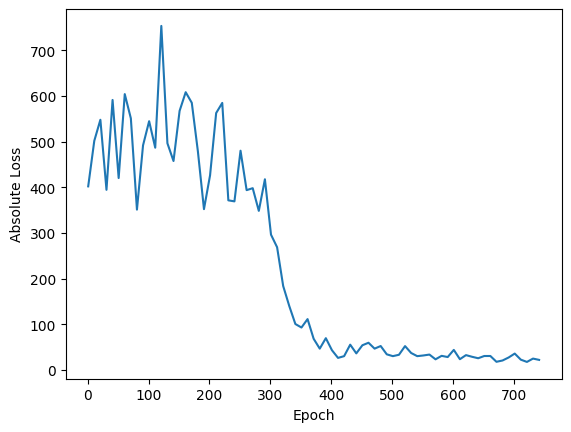

In [279]:
epochs = np.arange(1,751,10)
plt.xlabel("Epoch")
plt.ylabel("Absolute Loss")
plt.plot(epochs,losses)

Evaluate and compare random example's predicted value vs real value:

In [280]:
x,y = generate_data(-100,100,1)

with torch.no_grad():
    q4_model.eval()
    y_pred = q4_model(x)
l1 = criterion(y_pred,y).item()

print(f'x1, x2 = {x[0][0]:.6f}, {x[0][1]:.6f}')
print(f'Predicted vs Actual value: {y_pred[0][0]:.6f} vs {y[0][0]:.6f}')
print(f'Test L1 Loss: {l1:.6f}')

x1, x2 = 17.959717, -81.495560
Predicted vs Actual value: -1474.856812 vs -1463.637229
Test L1 Loss: 11.219582


Generate 100 random samples to test and evaluate average loss within range of training data:

In [281]:
x_val,y_val = generate_data(-100,100,100)
q4_model.eval()

total_loss = 0
for i in range(100):
    with torch.no_grad():
        y_pred = q4_model(x_val[i])
        l1 = criterion(y_pred,y_val[i])
    total_loss+=l1

print(f'Average loss within range of training data = {total_loss/100:.6f}')

Average loss within range of training data = 16.786459


Generate 100 random samples outside range of training data and calculate average loss:

In [282]:
x_test_neg,y_test_neg = generate_data(-500,-100,50)
x_test_pos,y_test_pos = generate_data(100.01,500,50)

total_loss = 0
for i in range(50):
    with torch.no_grad():
        y_pred = q4_model(x_test_neg[i])
        l1 = criterion(y_pred,y_test_neg[i])
    total_loss+=l1

for i in range(50):
    with torch.no_grad():
        y_pred = q4_model(x_test_pos[i])
        l1 = criterion(y_pred,y_test_pos[i])
    total_loss+=l1

print(f'Average loss outside range of training data = {total_loss/100:.6f}')

Average loss outside range of training data = 47902.598632


# Q5:

In [ ]:
!wget https://www-users.york.ac.uk/~waps101/PADL/clocks_dataset.zip
!unzip clocks_dataset.zip

(a)

The Dataset for the clock images. It takes the image directory as a parameter. An image is read using the read_image function and converted to the correct datatype, and a label is read from the corresponding txt file and returned as a tuple containing a float value for the hour and minute.

In [284]:
class ClocksDataset(Dataset):
    """Custom Clocks Dataset"""

    def __init__(self,img_dir,transforms=None):

        self.img_dir = img_dir
        self.transforms=transforms

        images = []
        labels = []

        for i in range(10000):
            images.append(f"{i:04d}.png")
            labels.append(f"{i:04d}.txt")

        self.images = sorted(images)
        self.labels = sorted(labels)

    def __len__(self):
        return len(self.images)

    def __getitem__(self,idx):
        img_path = self.images[idx]
        label_path = self.labels[idx]
        if self.transforms:
            PIL_image = PIL.Image.open(self.img_dir + img_path)
            PIL_image = self.transforms(PIL_image)
            image = PIL_image.to(torch.float32)/255.0
        else:
            image = (read_image(self.img_dir + img_path)).to(torch.float32)/255.0

        label = self.read_label(self.img_dir + label_path)

        return image,label

    def read_label(self,label_path):
        with open(label_path) as label_file:
            raw_label = label_file.read()
        label_vals = raw_label.split(':')
        label_vals = [float(val) for val in label_vals]
        hours = label_vals[0]
        mins = label_vals[1]
        return torch.tensor((hours,mins), dtype=torch.float32)

In [285]:
batch_size = 32

# If running locally:
#dataset = ClocksDataset("clocks_dataset/train/")

# If using colab:
dataset = ClocksDataset("train/")
train_data,validation_data = torch.utils.data.random_split(dataset,[9920,80])

In [286]:
train_loader = DataLoader(train_data,batch_size=batch_size,shuffle=True)
valid_loader = DataLoader(validation_data,batch_size=batch_size,shuffle=True)

images,labels = next(iter(train_loader))
print(images.shape)
print(labels.shape)

torch.Size([32, 3, 448, 448])
torch.Size([32, 2])


(b)

The defined network architecture, with two outputs, hours and mins:

In [287]:
class ClocksCNN(nn.Module):
    def __init__(self):
        super(ClocksCNN,self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=16,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2), # 16 x 224 x 224
            nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2), # 32 x 112 x 112
            nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2), # 64 x 56 x 56
            nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4,stride=4), # 128 x 14 x 14
            nn.Flatten(),
            nn.Dropout(0.5)
        )

        self.MLPhours = nn.Sequential(
            nn.Linear(in_features=128*14*14,out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128,out_features=12)
        )

        self.MLPmins = nn.Sequential(
            nn.Linear(in_features=128*14*14,out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64,out_features=1)
        )


    def forward(self,x):
        x = self.layers(x)
        x = x.view(x.size(0),-1)
        hours = self.MLPhours(x)
        mins = self.MLPmins(x)
        return hours,mins.view(-1)

q5_model = ClocksCNN()

In [288]:
total_params = sum(p.numel() for p in q5_model.parameters() if p.requires_grad)
print(total_params)

4916621


(c)

The chosen loss function for predicting the hours hand is Cross Entropy loss, as the network is predicting a class for the hours hand, 1-12.

The chosen loss function for predicting the minutes hand is Mean Squared Error loss, as the network is predicting the minutes value using regression.

In [289]:
criterion_h = nn.CrossEntropyLoss()
criterion_m = nn.MSELoss()

The training loop for the network, training each output of the network using its corresponding loss function. Their losses are weighted by a constant and summed to get the total loss for that iteration.

In [290]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

q5_model = q5_model.to(device)
q5_model.train()

num_epochs = 10
optim = torch.optim.SGD(q5_model.parameters(),lr=0.005)
iterations_per_epoch=300

losses_h, losses_m, losses_h_v, losses_m_v = [],[],[],[]

for epoch in range(num_epochs):
    for i,(images,labels) in enumerate(train_loader):
        images,labels = images.to(device),labels.to(device)
        labels_h,labels_m = labels[:,0],labels[:,1]
        h,m = q5_model(images)
        loss1 = criterion_h(h,labels_h.long())
        loss2 = criterion_m(m,labels_m)
        loss = loss1/3 + loss2/100
        optim.zero_grad()
        loss.backward()
        optim.step()

        if (i+1)%50 == 0:
            losses_h.append(loss1.item())
            losses_m.append(loss2.item())

        if (i+1)%100 == 0:
            print('Epoch [{}/{}], Iteration [{}/{}], Loss (hours): {:.4f}, Loss (mins): {:.4f}'.format(epoch+1, num_epochs, i+1, iterations_per_epoch, loss1.item(), loss2.item()))

        # Calculate loss on one batch in validation set
        images_v,labels_v = next(iter(valid_loader))
        images_v,labels_v = images_v.to(device),labels_v.to(device)
        labels_h_v,labels_m_v = labels_v[:,0],labels_v[:,1]
        h_v,m_v = q5_model(images_v)
        loss1_v = criterion_h(h_v,labels_h_v.long())
        loss2_v = criterion_m(m_v,labels_m_v)
        loss_v = loss1_v/3 + loss2_v/100

        if (i+1)%50 == 0:
            losses_h_v.append(loss1_v.item())
            losses_m_v.append(loss2_v.item())

Epoch [1/10], Iteration [100/300], Loss (hours): 2.0852, Loss (mins): 225.9256
Epoch [1/10], Iteration [200/300], Loss (hours): 1.6833, Loss (mins): 228.5517
Epoch [1/10], Iteration [300/300], Loss (hours): 1.5380, Loss (mins): 198.2852
Epoch [2/10], Iteration [100/300], Loss (hours): 1.1798, Loss (mins): 239.9072
Epoch [2/10], Iteration [200/300], Loss (hours): 1.1252, Loss (mins): 99.9195
Epoch [2/10], Iteration [300/300], Loss (hours): 1.0246, Loss (mins): 110.5184
Epoch [3/10], Iteration [100/300], Loss (hours): 0.7140, Loss (mins): 219.0214
Epoch [3/10], Iteration [200/300], Loss (hours): 0.9279, Loss (mins): 113.1663
Epoch [3/10], Iteration [300/300], Loss (hours): 0.5916, Loss (mins): 97.9177
Epoch [4/10], Iteration [100/300], Loss (hours): 0.6339, Loss (mins): 119.2580
Epoch [4/10], Iteration [200/300], Loss (hours): 1.0286, Loss (mins): 82.1857
Epoch [4/10], Iteration [300/300], Loss (hours): 0.6429, Loss (mins): 93.3463
Epoch [5/10], Iteration [100/300], Loss (hours): 1.0115,

Export network weights

In [333]:
torch.save(q5_model.state_dict(),'weights.pkl')

Text(0.5, 1.0, 'Hours train loss')

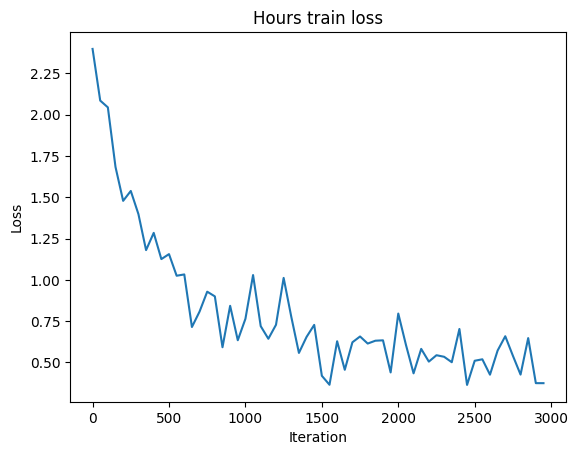

In [292]:
x = np.arange(0,3000,50)
losses_h_plot = [val for val in losses_h]
plt.plot(x,losses_h_plot)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Hours train loss")

Text(0.5, 1.0, 'Minutes train loss')

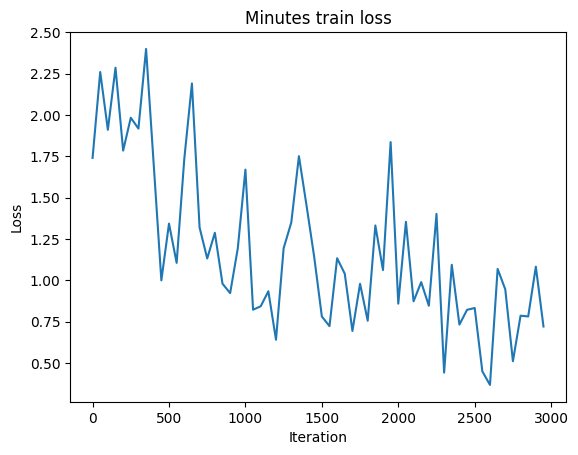

In [293]:
losses_m_plot = [val/100 for val in losses_m]
plt.plot(x,losses_m_plot)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Minutes train loss")

Text(0.5, 1.0, 'Hours validation loss')

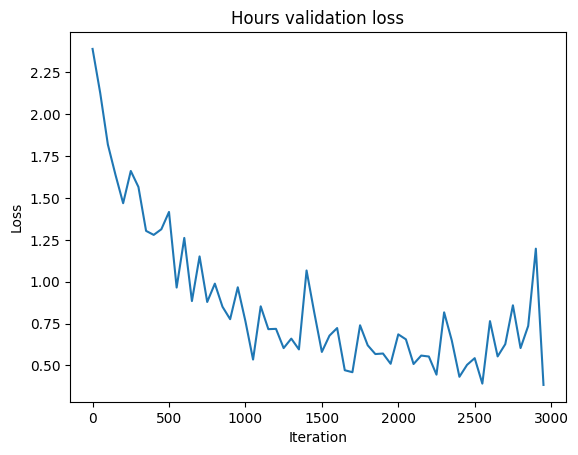

In [294]:
losses_h_v_plot = [val for val in losses_h_v]
plt.plot(x,losses_h_v_plot)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Hours validation loss")

Text(0.5, 1.0, 'Minutes validation loss')

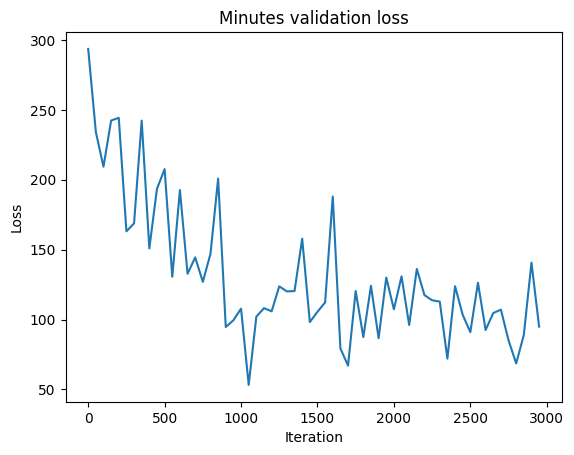

In [295]:
losses_m_v_plot = [val for val in losses_m_v]
plt.plot(x,losses_m_v_plot)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Minutes validation loss")

Make predictions on validation set with trained model:

In [309]:
def time_diff(hpred,mpred,h_real,m_real):
    mins_pred = hpred*60 + mpred
    mins_real = h_real*60 + m_real

    diff = abs(mins_real-mins_pred)
    return min(diff,720-diff)

Actual time: 11:52
Predicted time: 11:51
Error: 1


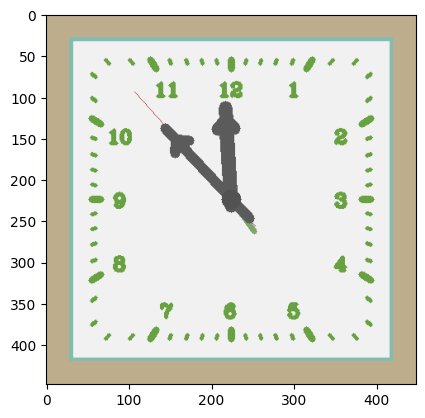

In [342]:
# Make a prediction on an item from the validation set and display

device = torch.device("cpu")
q5_model = q5_model.to(device)
q5_model.load_state_dict(torch.load("weights.pkl"))
q5_model.eval()
images_v, labels_v = next(iter(valid_loader))

pred_h_valid,pred_m_valid = q5_model(images_v)

actual_time = (int(labels_v[0][0]),int(labels_v[0][1]))
# if minutes is over 60, add however many hours to the hours value and use the remainder for minutes
prediction_mins = divmod(int(round(pred_m_valid[0].item())),60)
predicted_time = (int(pred_h_valid[0].argmax().item())+prediction_mins[0],prediction_mins[1])
plt.imshow(images_v[0].permute(1,2,0))
print("Actual time: %d:%d"%(actual_time[0],actual_time[1]))
print("Predicted time: %d:%d"%(predicted_time[0],predicted_time[1]))
print("Error: %d"%time_diff(predicted_time[0],predicted_time[1],actual_time[0],actual_time[1]))

Make predictions on a batch from the validation set and report the median error in minutes of that prediction:

In [347]:
device = torch.device("cpu")
q5_model = q5_model.to(device)
q5_model.load_state_dict(torch.load("weights.pkl"))
q5_model.eval()
valid_errors = []
images_v, labels_v = next(iter(valid_loader))
h_pred,m_pred = q5_model(images_v)
for i in range(1):
    for j in range(len(h_pred)):
        actual_time = (int(labels_v[j][0]),int(labels_v[j][1]))

        prediction_mins = divmod(int(round(m_pred[j].item())),60)
        predicted_time = (int(h_pred[j].argmax().item())+prediction_mins[0],prediction_mins[1])
        valid_errors.append(time_diff(predicted_time[0],predicted_time[1],actual_time[0],actual_time[1]))

In [348]:
valid_errors = np.sort(valid_errors)
np.median(valid_errors)

6.5

# Q6:

Define hyperparameters:

In [300]:
# hyperparameters
nz = 100 # size of z vector (generator input)
nc = 3 # number of input channels (colour image so 3)
ngf = 32 # size of feature maps in generator
ndf = 32 # size of feature maps in discriminator

batch_size = 64
num_epochs = 5
lr = 0.0002
beta1 = 0.5

Create dataloader and apply preprocessing:

In [314]:
transform = transforms.Compose([transforms.ToTensor(),transforms.CenterCrop(336),transforms.Normalize(0.5,0.5)])
# When running locally:
#dataset = ClocksDataset("clocks_dataset/train/",transforms=transform)
# When running in colab
dataset = ClocksDataset("train/",transforms=transform)
dataloader = DataLoader(dataset, batch_size=batch_size,shuffle=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Display a batch of training images:

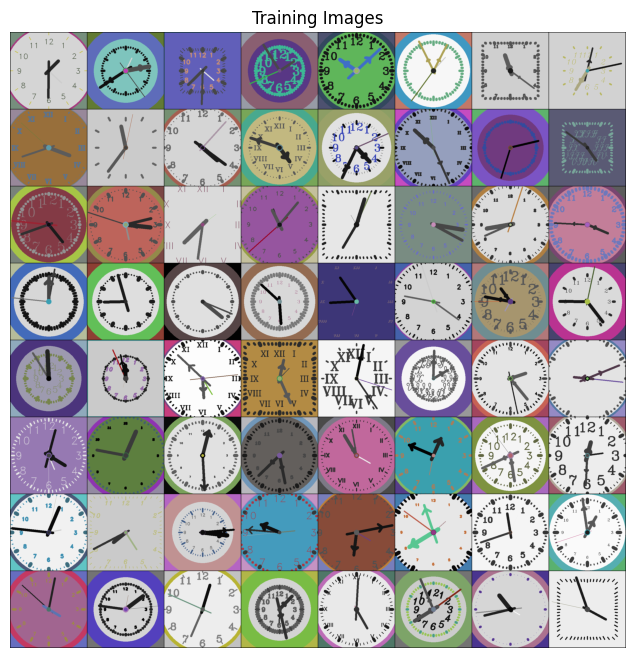

In [315]:
import torchvision.utils as vutils
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

Define generator architecture:

In [316]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.layers = nn.Sequential(
            # Z of size B x nz x 1 x 1
            nn.ConvTranspose2d(nz, ngf*8,4,1,0,bias=False),
            nn.BatchNorm2d(ngf*8),
            nn.ReLU(True),
            # Size B x (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf*8,ngf*4,4,2,1,bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # Size B x (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # Size B x (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # Size B x (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # B x (nc) x 64 x 64
        )

    def forward(self, input):
        return self.layers(input)

In [322]:
netG = Generator().to(device)

Define discriminator architecture:

In [328]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(nc,ndf,4,2,1,bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # Size B x (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # Size (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # Size(ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # Size (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid(),
            nn.Flatten(),
            nn.Linear(324,1)
        )

    def forward(self,input):
        return self.layers(input)

In [329]:
netD = Discriminator().to(device)

Training loop, loss function and optimisers:

In [330]:
criterion_q6 = nn.BCELoss()

real_label = 1
fake_label = 0

optimizerD = torch.optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = torch.optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [331]:
for epoch in range(num_epochs):
    for i, (images,labels) in enumerate(dataloader,0):
        # Update D network
        # Real batch
        netD.zero_grad()
        real_images = images.to(device)
        label = torch.full((batch_size,),real_label, dtype=torch.float32,device=device)

        output = netD(real_images).view(-1)
        errD_real = criterion_q6(output,label)
        errD_real.backward()

        D_x = output.mean().item()

        # Fake batch
        z = torch.randn(batch_size,nz,1,1,device=device)
        fake = netG(z)
        label.fill_(fake_label)

        output = netD(fake.detach()).view(-1)
        errD_fake = criterion_q6(output,label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()

        errD = errD_real + errD_fake
        optimizerD.step()

        # Update G network
        netG.zero_grad()
        label.fill_(real_label)

        output = netD(fake).view(-1)
        errG = criterion_q6(output,label)
        errG.backward()

        D_G_z2 = output.mean().item()
        optimizerG.step()

        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch+1, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
